### STATS 202 
Waseh Ahmad
Summer 2019

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [13]:
#import statements
# import matplotlib.pyplot as plt
# from matplotlib.colors import Colormap
import random
import matplotlib
# matplotlib.use('Agg') # set the backend before importing pyplot

import matplotlib.pyplot as plt # etc. etc.

from matplotlib.colors import Colormap
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import warnings
import sklearn
from bayes_opt import BayesianOptimization
from scipy import stats
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score,cross_validate, GridSearchCV, GroupKFold
from sklearn import linear_model, kernel_ridge
from statsmodels.graphics.gofplots import ProbPlot
from scipy.cluster import hierarchy
from sklearn.preprocessing import normalize, scale, PolynomialFeatures
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import RFE 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report,log_loss
import xgboost as xgb
import patsy
import library
from mpl_toolkits.mplot3d import Axes3D

#panel data
from linearmodels import PanelOLS


warnings.filterwarnings('ignore')

### Load Data and variables

In [3]:
#load all studies
files = ['Study_A.csv','Study_B.csv','Study_C.csv','Study_D.csv','Study_E.csv']
trials = []
for file in files:
    trials.append(pd.read_csv(file))
    
allTrialsDF = pd.concat(trials)

#ERROR value in 'Country' variable needs to be corrected
#60014 --> USA
#60025 --> Russia
allTrialsDF['Country'][(allTrialsDF.Country == "ERROR") & (allTrialsDF.SiteID==60014)] = "USA"
allTrialsDF['Country'][(allTrialsDF.Country == "ERROR") & (allTrialsDF.SiteID==60025)] = "RUSSIA"


#Create dummy variables for Study
allTrialsDF['TxGroup'] = pd.factorize(allTrialsDF.TxGroup)[0]
#drop UK explictly instead of first
countryDummies = pd.get_dummies(allTrialsDF.Country,prefix='Country').drop(['Country_UK'],axis=1)
studyDummies = pd.get_dummies(allTrialsDF.Study,drop_first=True,prefix='Study')
# allTrialsDF = allTrialsDF.drop(['Country','Study'],axis=1)

allTrialsDF = pd.concat([allTrialsDF,countryDummies,studyDummies],axis=1)

#change lead status to binary values
factors = {'Passed': 0, 'Flagged': 1,'Assign to CS':1}
allTrialsDF['LeadStatus'].replace(factors,inplace = True)

In [4]:
# add variables for lag, diff, sums of (p,n,g)

#sort the data by patient and visits
allSortedDF = allTrialsDF.sort_values(['PatientID', 'VisitDay'], ascending=[True, True]).reset_index().drop(['index'],axis=1)

# Add relative visit day variable
for name,group in allSortedDF.groupby('PatientID').__iter__():
    idx = 0
    for row_index,row in group.iterrows():
        allSortedDF.at[row_index,'RelativeVisitDay'] = idx
        idx+=1

#get sum of Ps,Ns,Gs
Ps=['P1', 'P2', 'P3', 'P4', 'P5','P6', 'P7']
Gs=['G1','G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15','G16']
Ns=['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7']
allSortedDF['Ps'] = allSortedDF[Ps].sum(axis=1)
allSortedDF['Gs'] = allSortedDF[Gs].sum(axis=1)
allSortedDF['Ns'] = allSortedDF[Ns].sum(axis=1)

#diff of PANSS_Total
allSortedDF['PANSS_Total_diff_1'] = allSortedDF.groupby('PatientID')['PANSS_Total'].diff().fillna(0)

#get first lags for PANSS, Ps, Gs, Ns
for col in ['Ps','Ns','Gs','PANSS_Total','PANSS_Total_diff_1']:
    newCol = col+"_lag_1"
    allSortedDF[newCol] = allSortedDF.groupby('PatientID')[col].shift(1)
    
#fill na for lags
allSortedDF['PANSS_Total_lag_1'] = allSortedDF['PANSS_Total_lag_1'].fillna(allSortedDF.PANSS_Total)
# let values of nan for lag of diff (occurs when visit day= 0), equal 0
allSortedDF['PANSS_Total_diff_1_lag_1'] = allSortedDF['PANSS_Total_diff_1_lag_1'].fillna(0)
allSortedDF['Gs_lag_1'] = allSortedDF['Gs_lag_1'].fillna(allSortedDF.Gs)
allSortedDF['Ns_lag_1'] = allSortedDF['Ns_lag_1'].fillna(allSortedDF.Ns)
allSortedDF['Ps_lag_1'] = allSortedDF['Ps_lag_1'].fillna(allSortedDF.Ns)

In [249]:
hypotDF = allSortedDF
hypotDF['PatientID'] = pd.Categorical(hypotDF['PatientID'])
# type(hypotDF['PatientID'][20])

formula = "PANSS_Total_diff_1 ~ TxGroup + VisitDay + PatientID"
olsModel = smf.ols(formula,data=allSortedDF).fit()
olsModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     PANSS_Total_diff_1   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.7978
Date:                Tue, 13 Aug 2019   Prob (F-statistic):               1.00
Time:                        18:20:28   Log-Likelihood:                -75882.
No. Observations:               22909   AIC:                         1.577e+05
Df Residuals:                   19961   BIC:                         1.814e+05
Df Model:                        2947                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -5.3548      2.689     -1.991      0.046     -10.626      -0.083
PatientID[T.10002]     8.2926      4.910      1.689      0.091      -1.332      17.917
PatientID[T.10003]     4.5061      2.904      1.551      0.121      -1.187      10.199
PatientID[T.10004]    -1.7672      2.516     -0.702      0.482      -6.698       3.164
PatientID[T.10005]     0.4219      3.586      0.118      0.906      -6.607       7.451
PatientID[T.10006]    -1.8123      2.372     -0.764      0.445      -6.462       2.837
PatientID[T.10007]     9.8254      3.557      2.763      0.006       2.854      16.797
PatientID[T.10008]    -1.0278      2.689     -0.382      0.702      -6.299       4.243
PatientID[T.10009]     2.8108      3.557      0.790      0.429      -4.160       9.782
PatientID[T.10010]     2.9709      4.910      0.605      0.545      -6.653      12.595
PatientID[T.10011]     2.5201      3.586      0.703      0.482      -4.509       9.549
PatientID[T.10012]     5.7682      4.166      1.384      0.166      -2.398      13.935
PatientID[T.10013]    -1.6211      2.372     -0.683      0.494      -6.271       3.028
PatientID[T.10014]     3.7086      3.586      1.034      0.301      -3.320      10.737
PatientID[T.10015]     4.7160      4.106      1.148      0.251      -3.333      12.765
PatientID[T.10016]     5.5711      3.959      1.407      0.159      -2.188      13.330
PatientID[T.10017]    -3.5771      2.372     -1.508      0.132      -8.226       1.072
PatientID[T.10018]     0.7136      2.904      0.246      0.806      -4.979       6.407
PatientID[T.10019]     1.7319      3.586      0.483      0.629      -5.297       8.761
PatientID[T.10020]     0.9984      2.904      0.344      0.731      -4.695       6.691
PatientID[T.10021]    -3.4002      2.372     -1.433      0.152      -8.050       1.249
PatientID[T.10022]     2.0743      3.586      0.578      0.563      -4.954       9.103
PatientID[T.10023]    -2.6484      4.106     -0.645      0.519     -10.697       5.401
PatientID[T.10024]     2.6169      3.586      0.730      0.466      -4.412       9.646
PatientID[T.10025]     3.4472      3.959      0.871      0.384      -4.312      11.207
PatientID[T.10026]     4.2896      3.683      1.165      0.244      -2.929      11.508
PatientID[T.10027]     6.7752      4.166      1.626      0.104      -1.391      14.942
PatientID[T.10028]    -3.5927      3.683     -0.976      0.329     -10.811       3.626
PatientID[T.10029]    -1.7642      2.516     -0.701      0.483      -6.695       3.167
PatientID[T.10030]     0.8854      4.910      0.180      0.857      -8.739      10.510
PatientID[T.10031]    -4.8318      4.460     -1.083      0.279     -13.573       3.910
PatientID[T.10032]     4.6490      3.181      1.461      0.144      -1.587      10.885
PatientID[T.10033]     0.7112      3.5

# Patient Segmentation

In [6]:
firstVisits = allSortedDF.groupby('PatientID').first()[['PANSS_Total','Ps','Gs','Ns']]
# normalize the data and create a df out of it
firstVisitsScaled = normalize(firstVisits,axis=0)
firstVisitsScaledDF = pd.DataFrame(firstVisitsScaled, columns=firstVisits.columns)


labels = firstVisits.index.values
linked = hierarchy.linkage(firstVisitsScaledDF, 'complete',metric='euclidean')


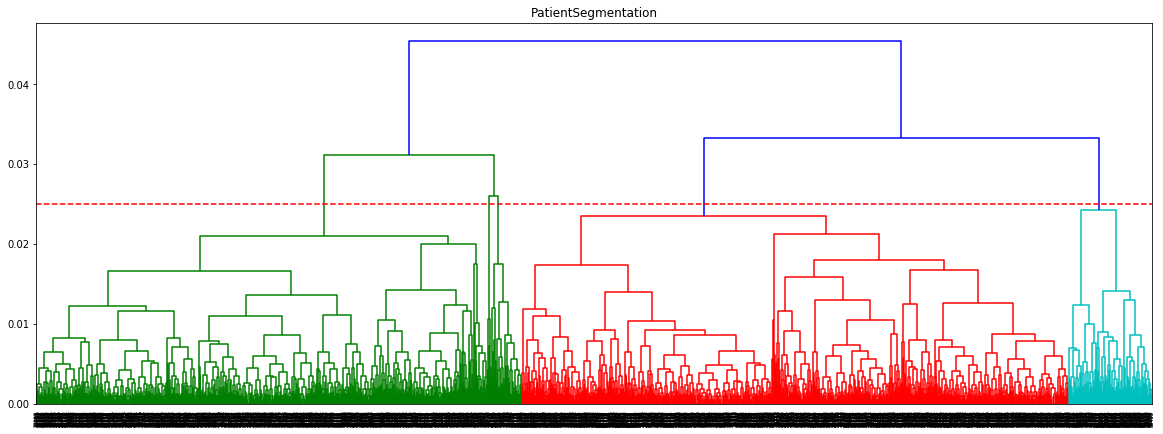

In [7]:
plt.figure(figsize=(20, 7))  
dendrogram = hierarchy.dendrogram(linked,labels=labels)
plt.title("PatientSegmentation")
plt.axhline(y=0.025, color='r', linestyle='--')
plt.show() 

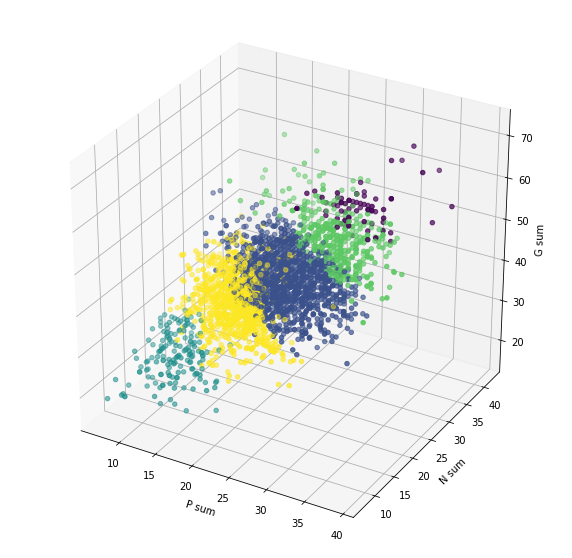

In [8]:
numClusters = 5
aggClustering = AgglomerativeClustering(n_clusters=numClusters, affinity='euclidean', linkage='complete')
aggClusteringFit = aggClustering.fit_predict(firstVisits)

# %matplotlib notebook
fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(firstVisits.Ps,firstVisits.Ns, firstVisits.Gs, c=aggClustering.labels_, cmap='viridis_r', marker='o')
# fig.colorbar(img)

ax.set_xlabel('P sum')
ax.set_ylabel('N sum')
ax.set_zlabel('G sum')

plt.show()


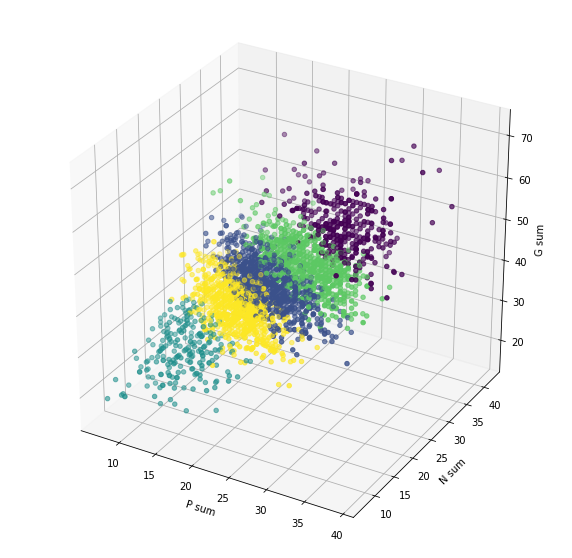

In [9]:
kNNCenters = []
#get centers from previous clustering
for k in np.unique(aggClusteringFit):
    #for each parameter
    kthMeans = []
    for p in firstVisits.columns:
        #compute mean
        kthMeans.append(np.mean(firstVisits[p].loc[aggClustering.labels_ == k]))
    kNNCenters.append(np.asarray(kthMeans))
    
kMeansClusters = KMeans(n_clusters=numClusters,init=np.asarray(kNNCenters),random_state=1).fit(firstVisits)

#plot
fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(firstVisits.Ps,firstVisits.Ns, firstVisits.Gs, c=kMeansClusters.labels_,cmap='viridis_r', marker='o')
# fig.colorbar(img)

ax.set_xlabel('P sum')
ax.set_ylabel('N sum')
ax.set_zlabel('G sum')

plt.show()

# Forecasting

In [5]:
#divide set into training and test data

#first, get all the possible attributes that we might want
studies = list(allSortedDF.columns[allSortedDF.columns.str.startswith("Study_")== True])
X = ['TxGroup','RelativeVisitDay','PANSS_Total_lag_1','PANSS_Total_diff_1_lag_1',
     'RaterID']+studies


# X = ['TxGroup','RelativeVisitDay','VisitDay','PANSS_Total_lag_1']+studies
y = ['PANSS_Total']

#remove first visits as we cannot use that to make predictions (there is no previous data on it)
forecastDF = allSortedDF
forecastDF['RaterID'] = pd.factorize(forecastDF['RaterID'])[0]

xSet = forecastDF[X]
ySet = forecastDF[y]

groups = forecastDF['PatientID']
patientsSplit = GroupKFold(n_splits=4)

for trainIndex, testIndex in patientsSplit.split(xSet, ySet, groups):
    xTrain, xTest = xSet.iloc[trainIndex], xSet.iloc[testIndex]
    yTrain, yTest = ySet.iloc[trainIndex], ySet.iloc[testIndex]
    trainGroups = forecastDF.iloc[trainIndex]['PatientID']
    testGroups = forecastDF.iloc[testIndex]['PatientID']

trainDF = pd.concat([xTrain,yTrain],axis=1)

In [6]:
#get ids of the users for whom we need to make predictions/classification
submissionIDs = pd.read_csv("sample_submission_PANSS.csv").PatientID

In [9]:
#make the prediction by first making the df for the features being used
extraCols = ['PANSS_Total_diff_1','PANSS_Total']
submissionXDF = allSortedDF.loc[allSortedDF.PatientID.isin(submissionIDs)][X+['PatientID']+extraCols]
submissionXDF = submissionXDF.groupby('PatientID').last()
for col in extraCols:
    submissionXDF[col+"_lag_1"] = submissionXDF[col]
submissionXDF = submissionXDF.drop(extraCols,axis=1)

In [90]:
#try linear regression
testMSEs = list()
trainMSEs = list()
for degree in range(1,4,1):
    linearModel = linear_model.LinearRegression()
    #training MSE
    lrCV = cross_validate(linearModel,
                          PolynomialFeatures(degree).fit_transform(xTrain),
                          yTrain['PANSS_Total'],
                          scoring='neg_mean_squared_error',groups=trainGroups)
    
    trainMSEs.append(lrCV['train_score'])
    #Test MSE
    testMSEs.append(lrCV['test_score'])


Train MSE:44.113477156031784
Test MSE:51.31414112737617


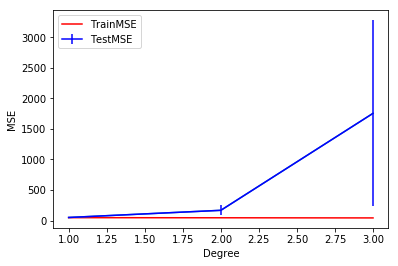

In [91]:
meanMSETrain = np.apply_along_axis(np.mean, 1, trainMSEs)
meanMSETest = np.apply_along_axis(np.mean, 1, testMSEs)
stdMSETest = np.apply_along_axis(stats.sem, 1, testMSEs)

xAxis = range(1,4,1)
plt.plot(xAxis,np.abs(meanMSETrain),c='red',label='TrainMSE')
plt.errorbar(xAxis,np.abs(meanMSETest),stdMSETest,c='blue',label='TestMSE')
plt.plot(xAxis,np.abs(meanMSETest))

plt.xlabel('Degree')
plt.ylabel('MSE')
plt.legend(loc='upper left')

print("Train MSE:"+str(np.min(np.abs(meanMSETrain))))
print("Test MSE:"+str(np.min(np.abs(meanMSETest))))

In [14]:
# Bagging approach
def bagging_regression_cv(
    degree,
    n_features_to_select,
    max_leaf_nodes,
    n_estimators):
    
    np.random.seed(5)
    baseModel = DecisionTreeRegressor(random_state=1234,max_leaf_nodes=int(max_leaf_nodes))

    baggingModelReg = Pipeline([
      ('transformation', PolynomialFeatures(degree=int(degree))),
      ('feature_selection', RFE(baseModel,n_features_to_select=int(n_features_to_select))),
      ('regression', BaggingRegressor(base_estimator=baseModel,n_estimators=int(n_estimators)))
    ])
    
    #run CV on pipeline
    scores = cross_val_score(baggingModelReg, 
                            xTrain,
                            yTrain, 
                            cv=4,
                            scoring='neg_mean_squared_error',
                            groups=trainGroups)
    return scores.mean()
    
params={'degree':(1,3),
        'n_features_to_select':(1,32),
        'max_leaf_nodes':(2,64),
        'n_estimators':(10,3000)}

baggOptimizerReg = BayesianOptimization(f=bagging_regression_cv,pbounds=params,random_state=1234,verbose=1)
#uncomment to run tuning
baggOptimizerReg.maximize(n_iter=10)


|   iter    |  target   |  degree   | max_le... | n_esti... | n_feat... |
-------------------------------------------------------------------------
|  2        | -50.66    |  2.56     |  18.9     |  836.6    |  25.86    |
|  13       | -50.66    |  2.411    |  18.94    |  836.3    |  26.09    |
|  15       | -49.87    |  1.705    |  17.83    |  836.0    |  25.31    |


In [15]:
print(baggOptimizerReg.max)


{'target': -49.869219568968305, 'params': {'degree': 1.7049149234902046, 'max_leaf_nodes': 17.827713106880374, 'n_estimators': 836.0471343878171, 'n_features_to_select': 25.305998974978575}}


In [16]:

np.random.seed(5)
baseModel = DecisionTreeRegressor(random_state=1234,max_leaf_nodes=int(baggOptimizerReg.max['params']['max_leaf_nodes']))

baggingModelReg = Pipeline([
  ('transformation', PolynomialFeatures(degree=int(baggOptimizerReg.max['params']['degree']))),
  ('feature_selection', RFE(baseModel,n_features_to_select=int(baggOptimizerReg.max['params']['n_features_to_select']))),
  ('regression', BaggingRegressor(base_estimator=baseModel,n_estimators=int(baggOptimizerReg.max['params']['n_estimators'])))
]) 

baggModelRegFit = baggingModelReg.fit(xTrain,yTrain)

yPredTrainBagReg = baggingModelReg.predict(xTrain)
yPredTestBagReg = baggingModelReg.predict(xTest)

print("Train MSE:"+str(library.GetMSE(yPredTrainBagReg,np.asarray(yTrain.PANSS_Total))))
print("Test MSE:"+str(library.GetMSE(yPredTestBagReg,np.asarray(yTest.PANSS_Total))))


Train MSE:46.64673733168282
Test MSE:42.31719514683581


In [19]:
predictions = baggingModelReg.predict(submissionXDF)
submission = pd.DataFrame(columns=['PatientID','PANSS_Total'])
submission['PANSS_Total'] = predictions
submission['PatientID'] = submissionIDs
submission.to_csv("regression_submissions/forecast_submit_bagg_decision_tree_Grouped.csv",index=False)

In [99]:

def xgb_cv(
    max_depth,
    learning_rate,
    min_child_weight,
    subsample,
    colsample_bytree,
    num_estimators):

    xgbModel = xgb.XGBRegressor(max_depth=int(max_depth),
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective='reg:squarederror',
                n_estimators=int(num_estimators),
                learning_rate=learning_rate).fit(xTrain,yTrain)
    cval = cross_val_score(xgbModel,xTrain,yTrain,scoring='neg_mean_squared_error',cv=4,groups=trainGroups)
    return cval.mean()

params={'max_depth':(2,8),
        'learning_rate':(0.0001,0.01),
        'min_child_weight':(4,11),
        'subsample':(0.1,0.99),
        'colsample_bytree':(0.1,0.99),
        'num_estimators':(1000,5000)}
optimizer = BayesianOptimization(f=xgb_cv,pbounds=params,random_state=1234,verbose=1)
#uncomment to run tuning
optimizer.maximize(n_iter=10)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_es... | subsample |
-------------------------------------------------------------------------------------------------
|  3        | -49.83    |  0.7083   |  0.007156 |  4.222    |  7.928    |  3.012e+0 |  0.1123   |
|  6        | -49.61    |  0.6934   |  0.007464 |  4.386    |  7.931    |  3.012e+0 |  0.1141   |


In [100]:
print(optimizer.max)

{'target': -49.61067522510172, 'params': {'colsample_bytree': 0.6933753197833109, 'learning_rate': 0.007464091872387385, 'max_depth': 4.386303459801238, 'min_child_weight': 7.930561230218538, 'num_estimators': 3012.096881869099, 'subsample': 0.11411499514760928}}


In [92]:
# xgbModel = xgb.XGBRegressor(learning_rate =0.007822, n_estimators=2000,max_depth=int(3.64),min_child_weight=5.75,
#                                                    objective='reg:squarederror', seed=1)
# xgbGS1Fit = xgbModel.fit(xTrain, yTrain)
max_depth = int(4.386303459801238)
min_child_weight = 7.930561230218538
subsample = 0.11411499514760928
colsample_bytree = 0.6933753197833109
objective = 'reg:squarederror'
num_estimators = int(3012.096881869099)
learning_rate = 0.007464091872387385

boostModel = xgb.XGBRegressor(max_depth=max_depth,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective=objective,
                n_estimators=num_estimators,
                learning_rate=learning_rate)
boostModelFit = boostModel.fit(xTrain,yTrain)

yPredTrain = boostModelFit.predict(xTrain)
yPredTest = boostModelFit.predict(xTest)

print("Train MSE:"+str(library.GetMSE(yPredTrain,np.asarray(yTrain.PANSS_Total))))
print("Test MSE:"+str(library.GetMSE(yPredTest,np.asarray(yTest.PANSS_Total))))

Train MSE:40.727809910691164
Test MSE:38.59509472462252


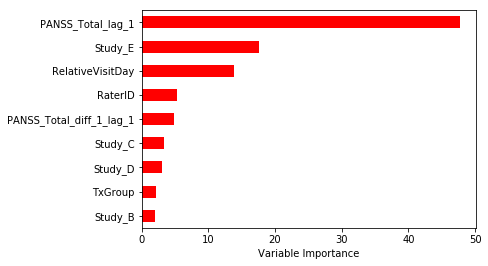

In [93]:
Importance = pd.DataFrame({'Importance':boostModelFit.feature_importances_*100}, index=xTrain.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [106]:
predictions = boostModel.predict(submissionXDF)
submission = pd.DataFrame(columns=['PatientID','PANSS_Total'])
submission['PANSS_Total'] = predictions
submission['PatientID'] = submissionIDs
submission.to_csv("regression_submissions/forecast_submit_XGB_Grouped.csv",index=False)

# Classification


In [107]:
def checkMultipleValuesShared(df,group,column):
    print(group+":"+str(sum(df.groupby([group])[column].unique().apply(lambda x:1 if len(x) > 1 else 0))>0))

# check if possible to have multiple studies with same values. 
checkMultipleValuesShared(allSortedDF,'Country','Study')
checkMultipleValuesShared(allSortedDF,'SiteID','Study')
checkMultipleValuesShared(allSortedDF,'PatientID','Study')
checkMultipleValuesShared(allSortedDF,'RaterID','Study')


Country:True
SiteID:False
PatientID:False
RaterID:False


In [172]:
#divide set into training and test data

#first, get all the possible attributes that we might want

# since each patient,site,Rater is unique to the study, cannot use those as features

countries = list(allSortedDF.columns[allSortedDF.columns.str.startswith("Country_")== True])
X = ['TxGroup','VisitDay','RelativeVisitDay','PANSS_Total_lag_1','PANSS_Total',
     'PANSS_Total_diff_1_lag_1','Ns_lag_1','Gs_lag_1','Ns','Gs']
# X = ['VisitDay','RelativeVisitDay']
y = ['LeadStatus']

#fill na for lags
allSortedDF['PANSS_Total_lag_1'] = allSortedDF['PANSS_Total_lag_1'].fillna(allSortedDF.PANSS_Total)
# let values of nan for lag of diff (occurs when visit day= 0), equal 0
allSortedDF['PANSS_Total_diff_1_lag_1'] = allSortedDF['PANSS_Total_diff_1_lag_1'].fillna(0)
allSortedDF['Gs_lag_1'] = allSortedDF['Gs_lag_1'].fillna(allSortedDF.Gs)
allSortedDF['Ns_lag_1'] = allSortedDF['Ns_lag_1'].fillna(allSortedDF.Ns)

groupVar = 'PatientID'

classificationDF = allSortedDF.loc[allSortedDF['Study_E'] == 0][X+y+[groupVar]]
resultDF = allSortedDF.loc[allSortedDF['Study_E'] == 1][X+['AssessmentiD']+[groupVar]]

xSet = classificationDF[X]
ySet = classificationDF[y]
# xTrain, xTest, yTrain, yTest = train_test_split(xSet, ySet, test_size=0.25, random_state=123456)
# trainDF = pd.concat([xTrain,yTrain],axis=1)

from sklearn.model_selection import GroupKFold

# need to do groupfold CV as we are creating probs for patients never seen before
groups = classificationDF[groupVar]
patientsSplit = GroupKFold(n_splits=2)

for trainIndex, testIndex in patientsSplit.split(xSet, ySet, groups):
    xTrain, xTest = xSet.iloc[trainIndex], xSet.iloc[testIndex]
    yTrain, yTest = ySet.iloc[trainIndex], ySet.iloc[testIndex]
    trainGroups = classificationDF.iloc[trainIndex][groupVar]
    testGroups = classificationDF.iloc[testIndex][groupVar]

Text(0, 0.5, 'VisitDay')

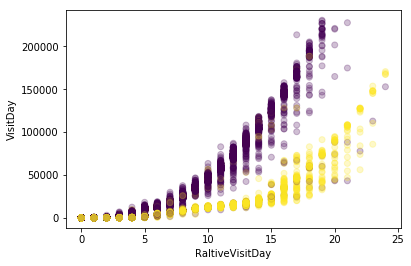

In [96]:
%matplotlib inline
#purple = pass,yellow = flagged/assigned
plt.scatter(xTrain.RelativeVisitDay,np.power(xTrain.VisitDay,2),c=list(yTrain.LeadStatus),alpha=0.25)
plt.xlabel("RaltiveVisitDay")
plt.ylabel("VisitDay")

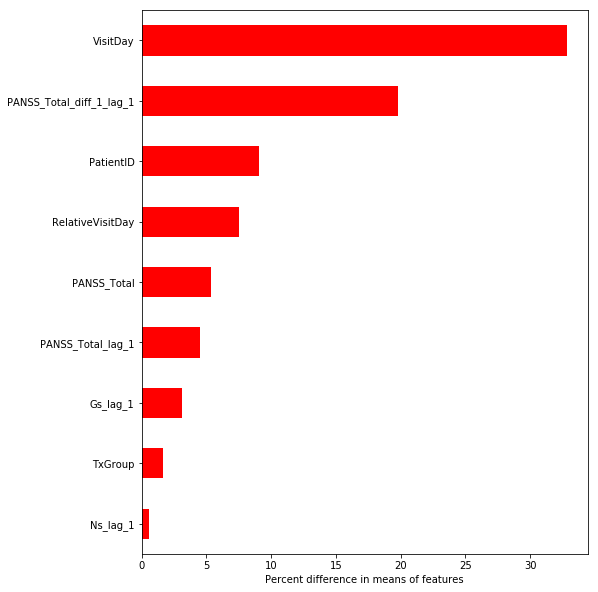

In [91]:
# visualize the difference in means of the LeadStatus groups based on the features
# have to drop UK as it is only in Study E, for whcih we do not have a lead status
means = classificationDF.groupby(['LeadStatus']).mean().transpose()
means['diff'] = 100*(means[0.0]-means[1.0])/means[0.0]

Importance = pd.DataFrame({'Importance':np.abs(means['diff'])}, index=means.index.values)

Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r',figsize=(8,10)) 
plt.xlabel('Percent difference in means of features')

plt.gca().legend_ = None


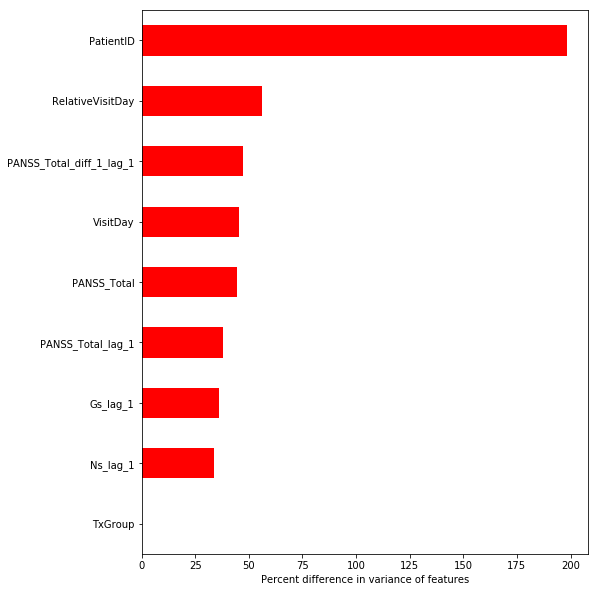

In [92]:
# visualize the difference in vars of the LeadStatus groups based on the features
# have to drop UK as it is only in Study E, for whcih we do not have a lead status
variances = classificationDF.groupby(['LeadStatus']).var().transpose()
variances['diff'] = 100*(variances[0.0]-variances[1.0])/variances[0.0]

Importance = pd.DataFrame({'Importance':np.abs(variances['diff'])}, index=variances.index.values)

Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r',figsize=(8,10)) 
plt.xlabel('Percent difference in variance of features')

plt.gca().legend_ = None

In [97]:
from sklearn.metrics import log_loss

testMSEs = []
trainMSEs = []
for k in range(30,200,5):
    # try KNN
    knnModel = KNeighborsClassifier(k)
#     knnModel.fit(xTrain,yTrain)
    knnCV = cross_validate(knnModel,xTrain,yTrain['LeadStatus'],scoring='neg_log_loss',groups=trainGroups)
#     #only get probs for class=1, i.e. notPassed
#     yPredTrain = knnModel.predict_proba(xTrain)[:,1]
#     trainMSEs.append(brier_score_loss(yTrain.LeadStatus,yPredTrain))
    
#     yPredTest = knnModel.predict_proba(xTest)[:,1]
    trainMSEs.append(knnCV['train_score'])
    testMSEs.append(knnCV['test_score'])

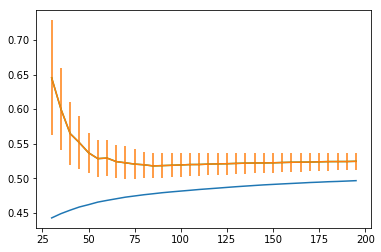

In [98]:
meanMSETrain = np.apply_along_axis(np.mean, 1, trainMSEs)
meanMSETest = np.apply_along_axis(np.mean, 1, testMSEs)
stdMSETest = np.apply_along_axis(stats.sem, 1, testMSEs)

xAxis = range(30,200,5)
plt.plot(xAxis,np.abs(meanMSETrain))
plt.errorbar(xAxis,np.abs(meanMSETest),stdMSETest)
plt.plot(xAxis,np.abs(meanMSETest))


### Tune and fit for XGB model

In [144]:
# try gradient boosting
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

def xgb_cv_classifier(
    max_depth,
    learning_rate,
    min_child_weight,
    subsample,
    colsample_bytree,
    num_estimators):

    xgbModel = xgb.XGBClassifier(max_depth=int(max_depth),
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective='binary:logistic',
                n_estimators=int(num_estimators),
                learning_rate=learning_rate,
                random_state=123).fit(xTrain,yTrain)
    
    cval = cross_val_score(xgbModel,xTrain,yTrain,scoring='neg_log_loss',cv=4,groups=trainGroups)
    return cval.mean()

params={'max_depth':(2,8),
        'learning_rate':(0.0001,0.01),
        'min_child_weight':(4,11),
        'subsample':(0.1,0.99),
        'colsample_bytree':(0.1,0.99),
        'num_estimators':(1000,5000)}

optimizer = BayesianOptimization(f=xgb_cv_classifier,pbounds=params,random_state=1234,verbose=1)
#uncomment to run tuning
optimizer.maximize(n_iter=10)



|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_es... | subsample |
-------------------------------------------------------------------------------------------------
|  10       | -0.4407   |  0.6905   |  0.004759 |  2.094    |  4.135    |  3.915e+0 |  0.8824   |
|  13       | -0.4392   |  0.6073   |  0.005899 |  2.126    |  4.08     |  3.362e+0 |  0.8598   |


In [145]:
print(optimizer.max)

{'target': -0.43917249932970964, 'params': {'colsample_bytree': 0.6073111561918005, 'learning_rate': 0.00589865212311415, 'max_depth': 2.1255364411201776, 'min_child_weight': 4.080382214025044, 'num_estimators': 3362.473369214361, 'subsample': 0.8598211980345092}}


In [201]:
max_depth = int(optimizer.max['params']['max_depth'])
min_child_weight = optimizer.max['params']['min_child_weight']
subsample = optimizer.max['params']['subsample']
colsample_bytree = optimizer.max['params']['colsample_bytree']
objective = 'binary:logistic'
num_estimators = int(optimizer.max['params']['num_estimators'])
learning_rate = optimizer.max['params']['learning_rate'] 

boostModel = xgb.XGBClassifier(max_depth=max_depth,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective=objective,
                n_estimators=num_estimators,
                learning_rate=learning_rate,
                random_state=1234)
boostModelFit = boostModel.fit(xTrain,yTrain)

yPredTrain = boostModelFit.predict_proba(xTrain)[:,1]
yPredTest = boostModelFit.predict_proba(xTest)[:,1]

print("Train Log loss:"+str(log_loss(yTrain.LeadStatus,yPredTrain)))
print("Test Log loss:" +str(log_loss(yTest.LeadStatus,yPredTest)))

Train Log loss:0.3867989217112141
Test Log loss:0.40505966685806255


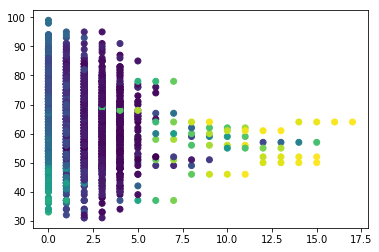

In [202]:
plt.scatter(resultDF.RelativeVisitDay,resultDF.PANSS_Total,c=boostModel.predict_proba(
    resultDF.drop(['AssessmentiD',groupVar],axis=1))[:,1])


### tuning and predictions for bagging - logistic regression

In [148]:
def bagging_cv_classifier_Logit(
    n_estimators,
    max_features,
    degree,C):

    dataSet = PolynomialFeatures(degree=int(degree)).fit_transform(xTrain)
    baseEstimator = linear_model.LogisticRegression(C=C)
    baggingClassifier = BaggingClassifier(baseEstimator,
                                          n_estimators=int(n_estimators),
                                          max_features=max_features,
                                          random_state=1234).fit(dataSet,yTrain)
    
    cval = cross_val_score(baggingClassifier,xTrain,yTrain,scoring='neg_log_loss',cv=4,groups=trainGroups)
    return cval.mean()

params={'max_features':(0.1,1.0),
        'n_estimators':(1,50),
        'degree':(1,3.1),
        'C':(0.001,1)}

baggOptimizerLogit = BayesianOptimization(f=bagging_cv_classifier_Logit,pbounds=params,random_state=1234,verbose=1)
#uncomment to run tuning
baggOptimizerLogit.maximize(n_iter=10)

|   iter    |  target   |     C     |  degree   | max_fe... | n_esti... |
-------------------------------------------------------------------------
|  3        | -0.5285   |  0.9582   |  2.839    |  0.422    |  25.55    |
|  5        | -0.4661   |  0.5036   |  1.029    |  0.7955   |  44.25    |


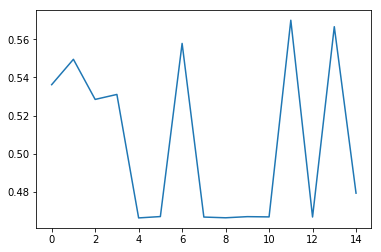

In [149]:
iterations=[]
ks=[]
for iter in baggOptimizerLogit.res:
    iterations.append(np.abs(iter['target']))
    ks.append(iter['params']['degree'])
plt.plot(range(len(iterations)),iterations)

In [190]:
print(baggOptimizerLogit.max)

degree = int(baggOptimizerLogit.max['params']['degree'])
trainDataBag=PolynomialFeatures(degree).fit_transform(xTrain)
testDataBag=PolynomialFeatures(degree).fit_transform(xTest)

C = baggOptimizerLogit.max['params']['C']
baggingClassifierLogit = BaggingClassifier(base_estimator=linear_model.LogisticRegression(C=C),
                                      n_estimators=int(baggOptimizerLogit.max['params']['n_estimators']),
                                      max_features=baggOptimizerLogit.max['params']['max_features'],
                                      random_state=1234)
baggingClassifierLogitFit = baggingClassifierLogit.fit(trainDataBag,yTrain)

yPredTrainBagLogit = baggingClassifierLogit.predict_proba(trainDataBag)[:,1]
yPredTestBagLogit = baggingClassifierLogit.predict_proba(testDataBag)[:,1]

print("Train Log loss:"+str(log_loss(yTrain.LeadStatus,yPredTrainBagKNN)))
print("Test Log loss:" +str(log_loss(yTest.LeadStatus,yPredTestBagKNN)))

{'target': -0.46614876433415803, 'params': {'C': 0.5035800821425019, 'degree': 1.0289137441404328, 'max_features': 0.7955439594511367, 'n_estimators': 44.249418341169715}}
Train Log loss:0.4322837099003158
Test Log loss:0.4374517408877687


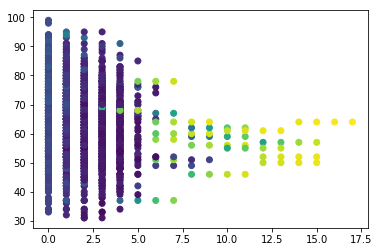

In [212]:
resultDataBag = PolynomialFeatures(degree).fit_transform(resultDF.drop(['AssessmentiD',groupVar],axis=1))
plt.scatter(resultDF.RelativeVisitDay,resultDF.PANSS_Total,c=baggingClassifierLogitFit.predict_proba(
    resultDataBag)[:,1])


In [ ]:
# Model for Calibrated classifier to take platt-scaling into account
from sklearn.calibration import CalibratedClassifierCV

base_estimator = LinearDiscriminantAnalysissis()
calibratedClassifierCalibratedClassifierCVCalibratedClassifierCV(base_estimator=base_estimator,
                                             method='sigmoid',
                                             cv=4,
                                             )

### Prediction of Logit with poly=3

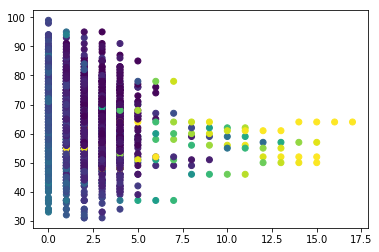

In [203]:
logitModel = linear_model.LogisticRegression().fit(PolynomialFeatures(3).fit_transform(xTrain),yTrain)

plt.scatter(resultDF.RelativeVisitDay,resultDF.PANSS_Total,c=logitModel.predict_proba(PolynomialFeatures(3).fit_transform(
    resultDF.drop(['AssessmentiD','PatientID'],axis=1)))[:,1])


### Submission forming For classification

In [31]:
    
submissionBC = pd.DataFrame(columns=['AssessmentiD','LeadStatus'])
submissionBC['AssessmentiD'] = resultDF.AssessmentiD
submissionBC['LeadStatus'] = (knnLogitAverage)
submissionBC.to_csv("classification_submissions/classification_submit_Logit.csv",index=False)

In [114]:

binaryClassification = boostModelFit.predict_proba(resultDF.drop(['AssessmentiD',binaryClassification = baggingClassifierFit.predict_proba(resultDF.drop(['AssessmentiD',groupVar],axis=1))[:,1]
],axis=1))[:,1]
    
submissionBC = pd.DataFrame(columns=['AssessmentiD','LeadStatus'])
submissionBC['AssessmentiD'] = resultDF.AssessmentiD
submissionBC['LeadStatus'] = (binaryClassification)
submissionBC.to_csv("classification_submissions/classification_submit_XGB.csv",index=False)

In [54]:

binaryClassification = baggingClassifierFit.predict_proba(resultDF.drop(['AssessmentiD',groupVar],axis=1))[:,1]
    
submissionBC = pd.DataFrame(columns=['AssessmentiD','LeadStatus'])
submissionBC['AssessmentiD'] = resultDF.AssessmentiD
submissionBC['LeadStatus'] = (binaryClassification)
submissionBC.to_csv("classification_submissions/classification_submit_bag_logit.csv",index=False)

### References
1. https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
2. https://www.scikit-yb.org/en/latest/api/regressor/residuals.html
3. https://github.com/fmfn/BayesianOptimization
